In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from scipy.stats import zscore
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')


In [3]:
# Merge datasets to combine customer and transaction data
merged_data = pd.merge(transactions, customers, on='CustomerID', how='left')

In [5]:
customer_profile = merged_data.groupby('CustomerID').agg(
    total_spending=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    unique_products=('ProductID', 'nunique')
).reset_index()

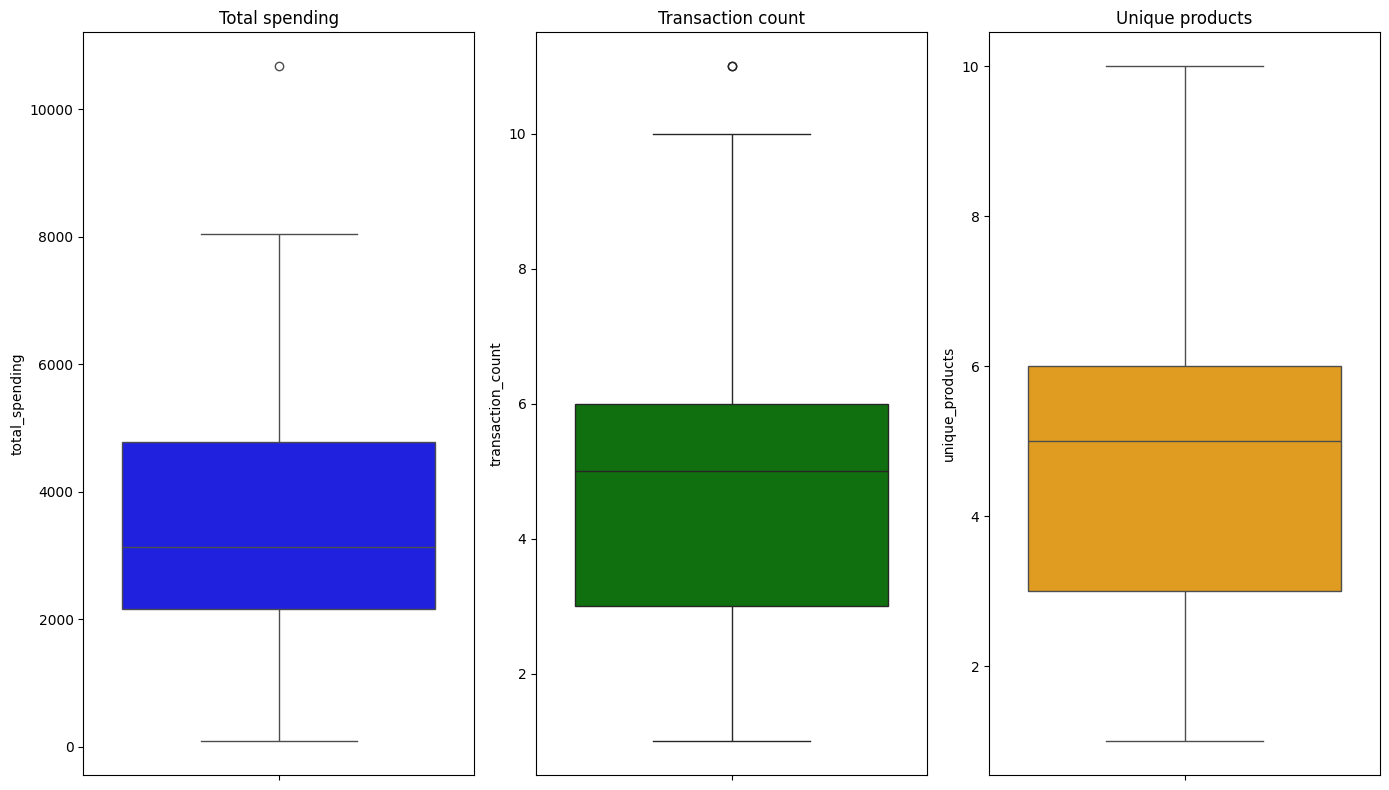

In [6]:
# Visualize potential outliers using boxplots
plt.figure(figsize=(14, 8))
for i, col in enumerate(['total_spending', 'transaction_count', 'unique_products'], start=1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=customer_profile[col], color=['blue', 'green', 'orange'][i - 1])
    plt.title(col.replace('_', ' ').capitalize())
plt.tight_layout()
plt.show()


In [7]:
for col in ['total_spending', 'transaction_count', 'unique_products']:
    customer_profile[f'z_{col}'] = zscore(customer_profile[col])


In [8]:
threshold = 3
outliers = customer_profile[
    (customer_profile['z_total_spending'].abs() > threshold) |
    (customer_profile['z_transaction_count'].abs() > threshold) |
    (customer_profile['z_unique_products'].abs() > threshold)
]
print(f"Number of outliers: {outliers.shape[0]}")


Number of outliers: 1


In [9]:
customer_profile_cleaned = customer_profile[
    (customer_profile['z_total_spending'].abs() <= threshold) &
    (customer_profile['z_transaction_count'].abs() <= threshold) &
    (customer_profile['z_unique_products'].abs() <= threshold)
]

In [10]:
customer_profile_cleaned.drop(columns=[f'z_{col}' for col in ['total_spending', 'transaction_count', 'unique_products']], inplace=True)


C:\Users\hasth\AppData\Local\Temp\ipykernel_32620\3362212140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_profile_cleaned.drop(columns=[f'z_{col}' for col in ['total_spending', 'transaction_count', 'unique_products']], inplace=True)


In [11]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profile_cleaned[['total_spending', 'transaction_count', 'unique_products']])

In [14]:
def dunn_index(X, labels):
    intra_cluster_distances = []
    inter_cluster_distances = []
    for i in np.unique(labels):
        cluster_i = X[labels == i]
        intra_cluster_distances.append(pairwise_distances(cluster_i).max())
        for j in np.unique(labels):
            if i != j:
                cluster_j = X[labels == j]
                inter_cluster_distances.append(pairwise_distances(cluster_i.mean(axis=0).reshape(1, -1), cluster_j.mean(axis=0).reshape(1, -1)))
    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)

In [15]:
k_range = range(2, 11)
sil_scores, db_scores, inertia_scores, calinski_scores, dunn_scores = [], [], [], [], []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    
    # Calculate clustering metrics
    sil_scores.append(silhouette_score(scaled_features, labels))
    db_scores.append(davies_bouldin_score(scaled_features, labels))
    inertia_scores.append(kmeans.inertia_)
    calinski_scores.append(calinski_harabasz_score(scaled_features, labels))
    dunn_scores.append(dunn_index(scaled_features, labels))


In [16]:
plt.figure(figsize=(15, 10))
metrics = [("Silhouette Score", sil_scores), ("Davies-Bouldin Index", db_scores), 
           ("Inertia", inertia_scores), ("Calinski-Harabasz Index", calinski_scores)]
colors = ['blue', 'red', 'green', 'purple']

<Figure size 1500x1000 with 0 Axes>

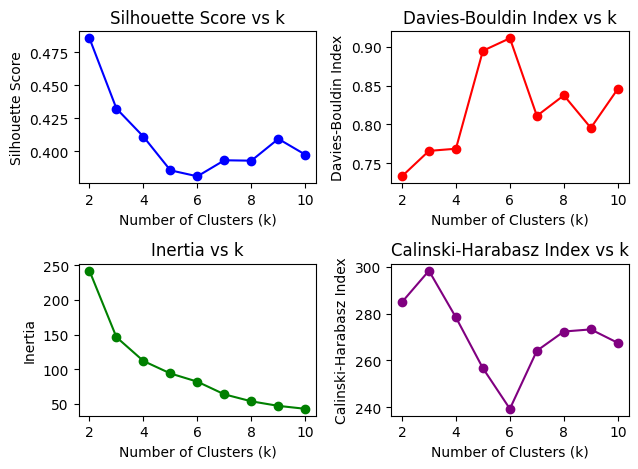

In [17]:
for i, (metric_name, metric_values) in enumerate(metrics, start=1):
    plt.subplot(2, 2, i)
    plt.plot(k_range, metric_values, marker='o', color=colors[i - 1])
    plt.title(f'{metric_name} vs k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel(metric_name)

plt.tight_layout()
plt.show()

In [18]:
best_k = k_range[np.argmin(db_scores)]
print(f"The best number of clusters based on DB Index is: {best_k}")


The best number of clusters based on DB Index is: 2


In [19]:
# Final clustering using the best k
kmeans = KMeans(n_clusters=best_k, random_state=42)
customer_profile_cleaned['cluster'] = kmeans.fit_predict(scaled_features)


C:\Users\hasth\AppData\Local\Temp\ipykernel_32620\1809117291.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_profile_cleaned['cluster'] = kmeans.fit_predict(scaled_features)


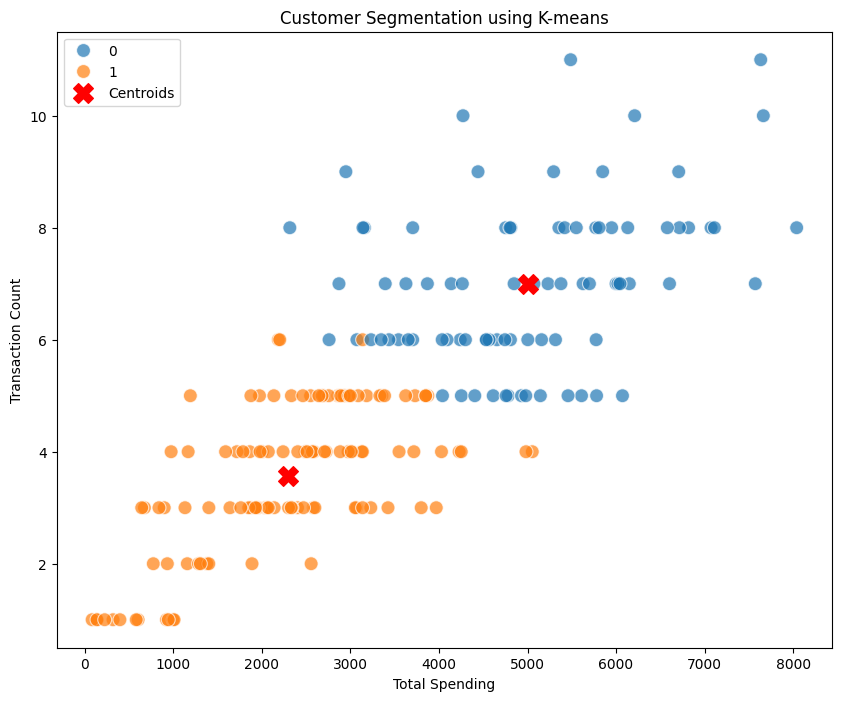

In [20]:
# Visualize clusters with centroids
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='total_spending', y='transaction_count', hue='cluster', data=customer_profile_cleaned, palette='tab10', s=100, alpha=0.7
)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label='Centroids')
plt.title('Customer Segmentation using K-means')
plt.xlabel('Total Spending')
plt.ylabel('Transaction Count')
plt.legend()
plt.show()